In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
# warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [36]:
# While we are grabbing an ML dataset, its best to bring in as a classic dataframe, for more genuine data-cleaning and EDA!

housing = fetch_openml(name='boston'
                      , version=1
                      , as_frame=True
                     )

df = pd.DataFrame(data=housing.data, columns=housing.feature_names)

df['target'] = housing.target

df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
 13  target   506 non-null    float64 
dtypes: category(2), float64(12)
memory usage: 49.0 KB


In [38]:
X = df.drop('target', axis=1)
y = df['target']

X.shape, y.shape

((506, 13), (506,))

In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y
    , test_size=0.2
    , random_state=27
)

In [40]:
# Scale the data!!!
scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [41]:
# ElasticNet model
elastic_net = ElasticNet(
    random_state=27
)

In [42]:
# Hyperparameter grid

# Clean, rounded hyperparams for better viz
alphas = np.round(np.logspace(-3, 2, 20), 6)
l1_ratios = np.round(np.linspace(0.1, 1, 10), 2)

param_grid = {
    'alpha': alphas
    , 'l1_ratio': l1_ratios
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=elastic_net
    , param_grid=param_grid
    , scoring='neg_mean_squared_error'
    , cv=5
)

In [43]:
# Fit grid search
grid_search.fit(scaled_X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_model

ElasticNet(alpha=0.037927, l1_ratio=0.1, random_state=27)

In [44]:
best_params

{'alpha': 0.037927, 'l1_ratio': 0.1}

In [45]:
# Predictions
y_pred = best_model.predict(scaled_X_test)

In [46]:
# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmse_ratio = rmse / np.mean(y_test)

In [47]:
metrics_summary = {
    'MAR': mae
    , 'RMSE': rmse
    , 'R² Score': r2
    , 'RMSE Ratio': rmse_ratio
}
metrics_summary

{'MAR': 3.5164789368085816,
 'RMSE': 5.25314588947901,
 'R² Score': 0.6954208009651397,
 'RMSE Ratio': 0.23318865032938427}

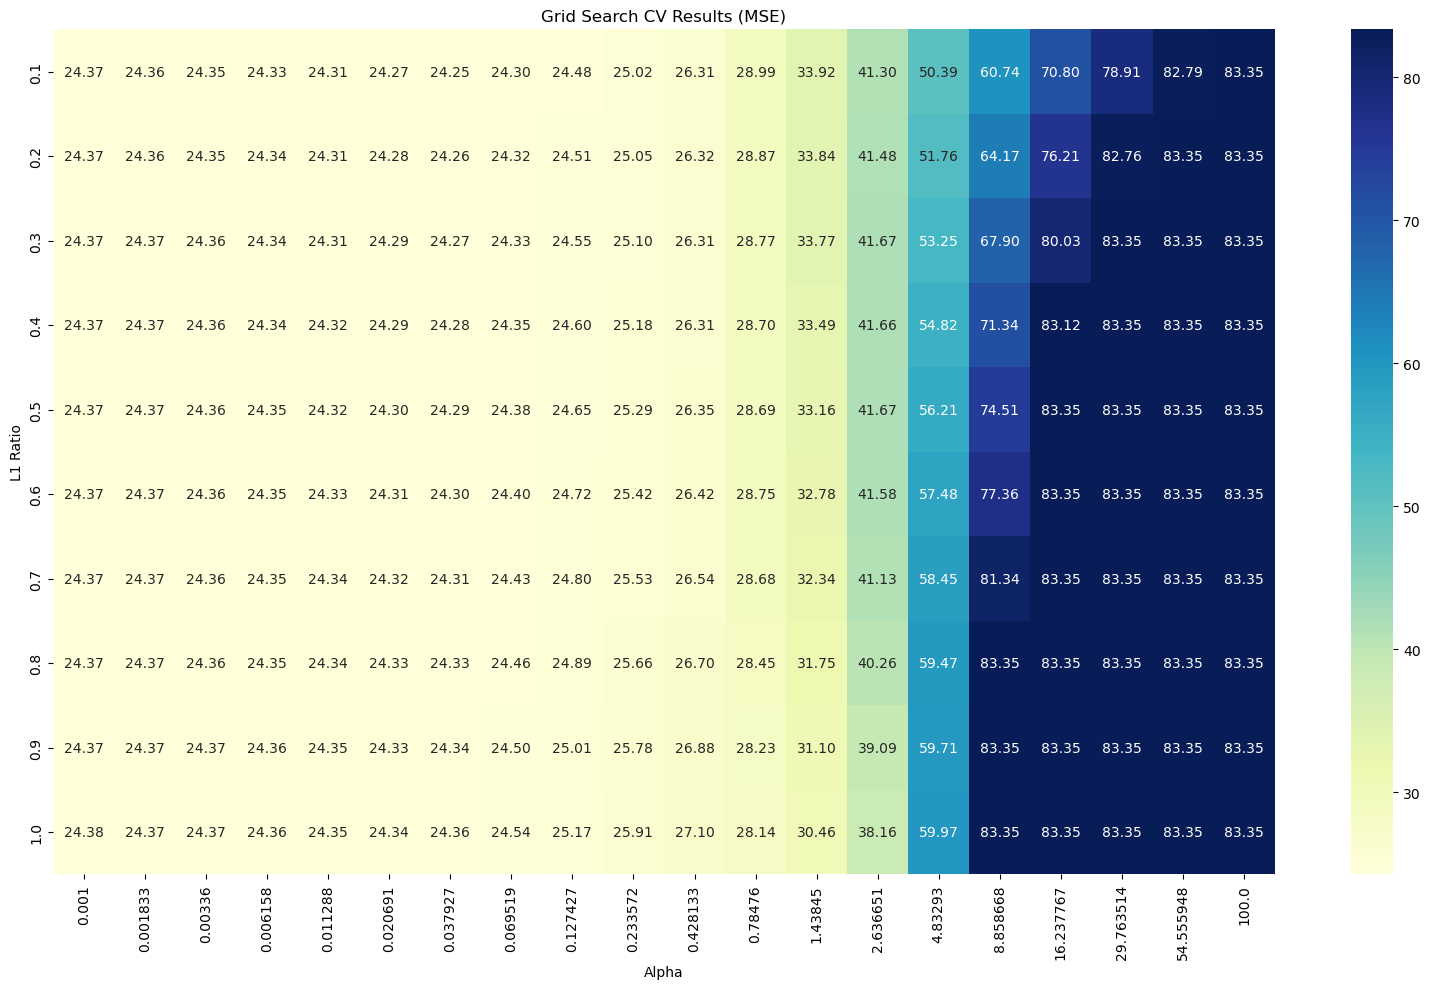

In [48]:
# Convert grid results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot table for heatmap
heatmap_data = results_df.pivot_table(
    index='param_l1_ratio'
    , columns='param_alpha'
    , values='mean_test_score')

# Convert scores from negative MSE to positive
heatmap_data = -1 * heatmap_data

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data
    , annot=True
    , fmt=".2f"
    , cmap="YlGnBu"
)
plt.title("Grid Search CV Results (MSE)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()

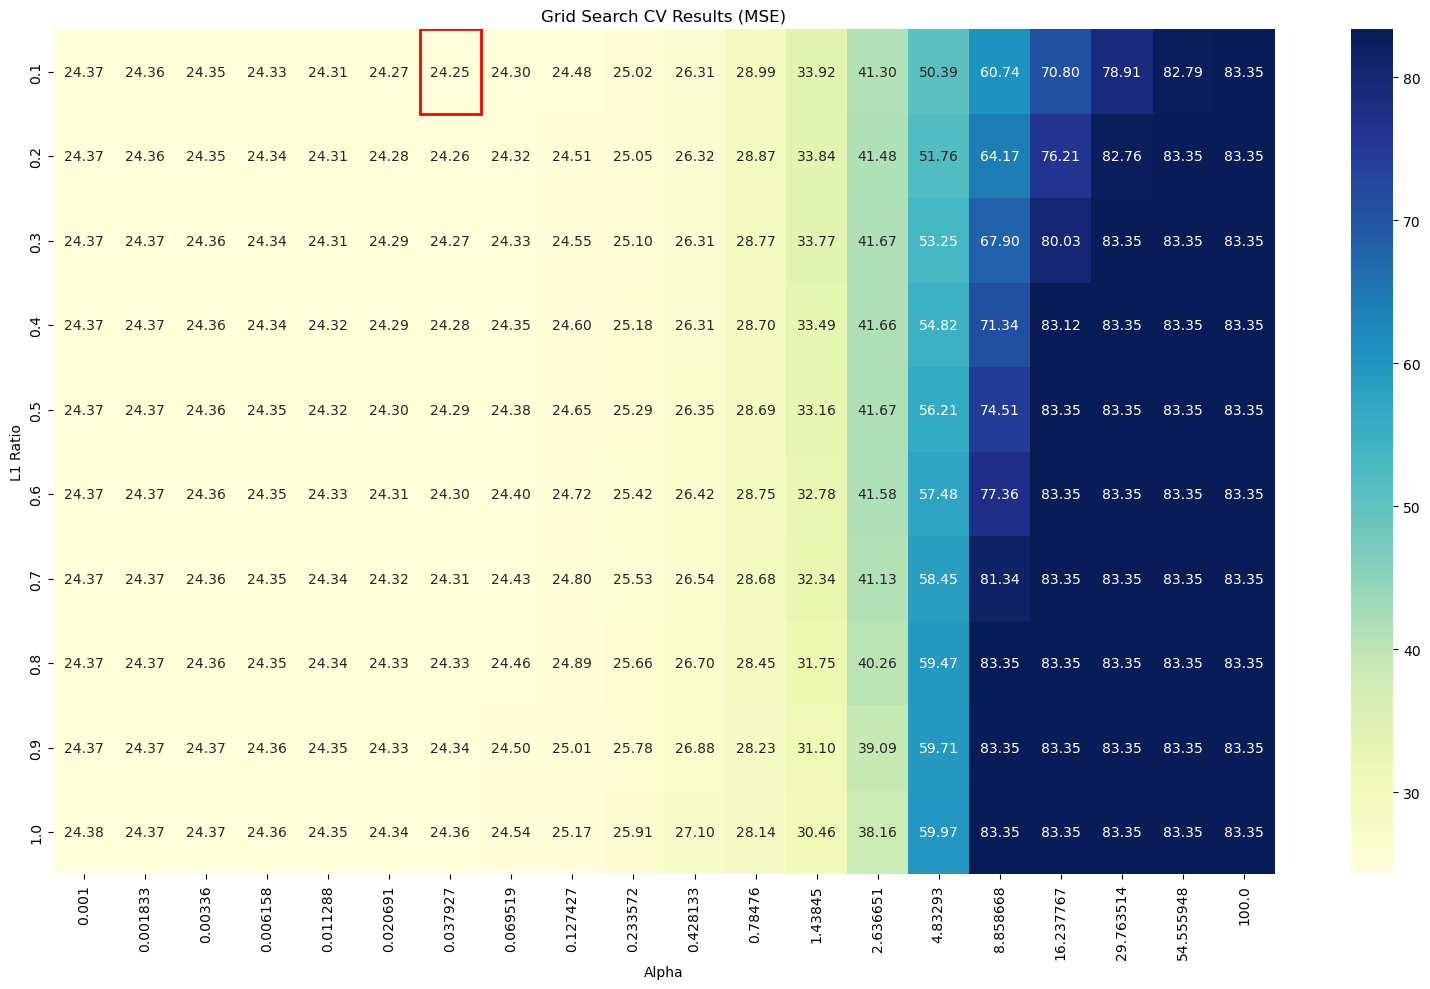

In [49]:
# UPDATE: Heatmap w/ best MSE marked by red box;

# Convert cv results to DataFrame
results_df = pd.DataFrame(
    grid_search.cv_results_)

# Pivot table for heatmap
heatmap_mse = results_df.pivot_table(
    index='param_l1_ratio'
    , columns='param_alpha'
    , values='mean_test_score')

# Convert from negative MSE to positive
heatmap_mse = -1 * heatmap_mse

# Identify the location of the best score (lowest MSE)
best_idx_mse = np.unravel_index(
    np.argmin(heatmap_mse.values)
    , heatmap_mse.shape)

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(heatmap_mse  
            , annot=True, fmt=".2f"
            , cmap="YlGnBu", ax=ax)

# Draw rectangle around best-performing cell
import matplotlib.patches as patches

highlight_rect = patches.Rectangle(
    (best_idx_mse[1], best_idx_mse[0])  # x, y
    , 1, 1, fill=False         # width, height
    , edgecolor='red'
    , linewidth=2)

ax.add_patch(highlight_rect)

plt.title("Grid Search CV Results (MSE)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show();

In [50]:
# Below is an alternate, custom way to use an RMSE as the scoring mechanism AND how to plot it on a heatmap AND draw a polygon around the best score!

In [51]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmse_ratio(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

rmse_scorer = make_scorer(rmse, greater_is_better=False)
rmse_ratio_scorer = make_scorer(rmse_ratio, greater_is_better=False)

In [53]:
grid_search_custom = GridSearchCV(
    estimator=elastic_net
    , param_grid=param_grid
    , scoring=rmse_ratio_scorer  # or rmse_scorer
    , cv=5
    , return_train_score=True
)

grid_search_custom.fit(scaled_X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=27),
             param_grid={'alpha': array([1.0000000e-03, 1.8330000e-03, 3.3600000e-03, 6.1580000e-03,
       1.1288000e-02, 2.0691000e-02, 3.7927000e-02, 6.9519000e-02,
       1.2742700e-01, 2.3357200e-01, 4.2813300e-01, 7.8476000e-01,
       1.4384500e+00, 2.6366510e+00, 4.8329300e+00, 8.8586680e+00,
       1.6237767e+01, 2.9763514e+01, 5.4555948e+01, 1.0000000e+02]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             return_train_score=True,
             scoring=make_scorer(rmse_ratio, greater_is_better=False))

In [54]:
# Best model
best_model_cust = grid_search_custom.best_estimator_
best_params_cust = grid_search_custom.best_params_

best_model_cust

ElasticNet(alpha=0.037927, l1_ratio=0.1, random_state=27)

In [55]:
best_params_cust

{'alpha': 0.037927, 'l1_ratio': 0.1}

In [56]:
best_score_cust_RMSE = grid_search_custom.best_score_
best_score_cust_RMSE 

-0.21652964763495425

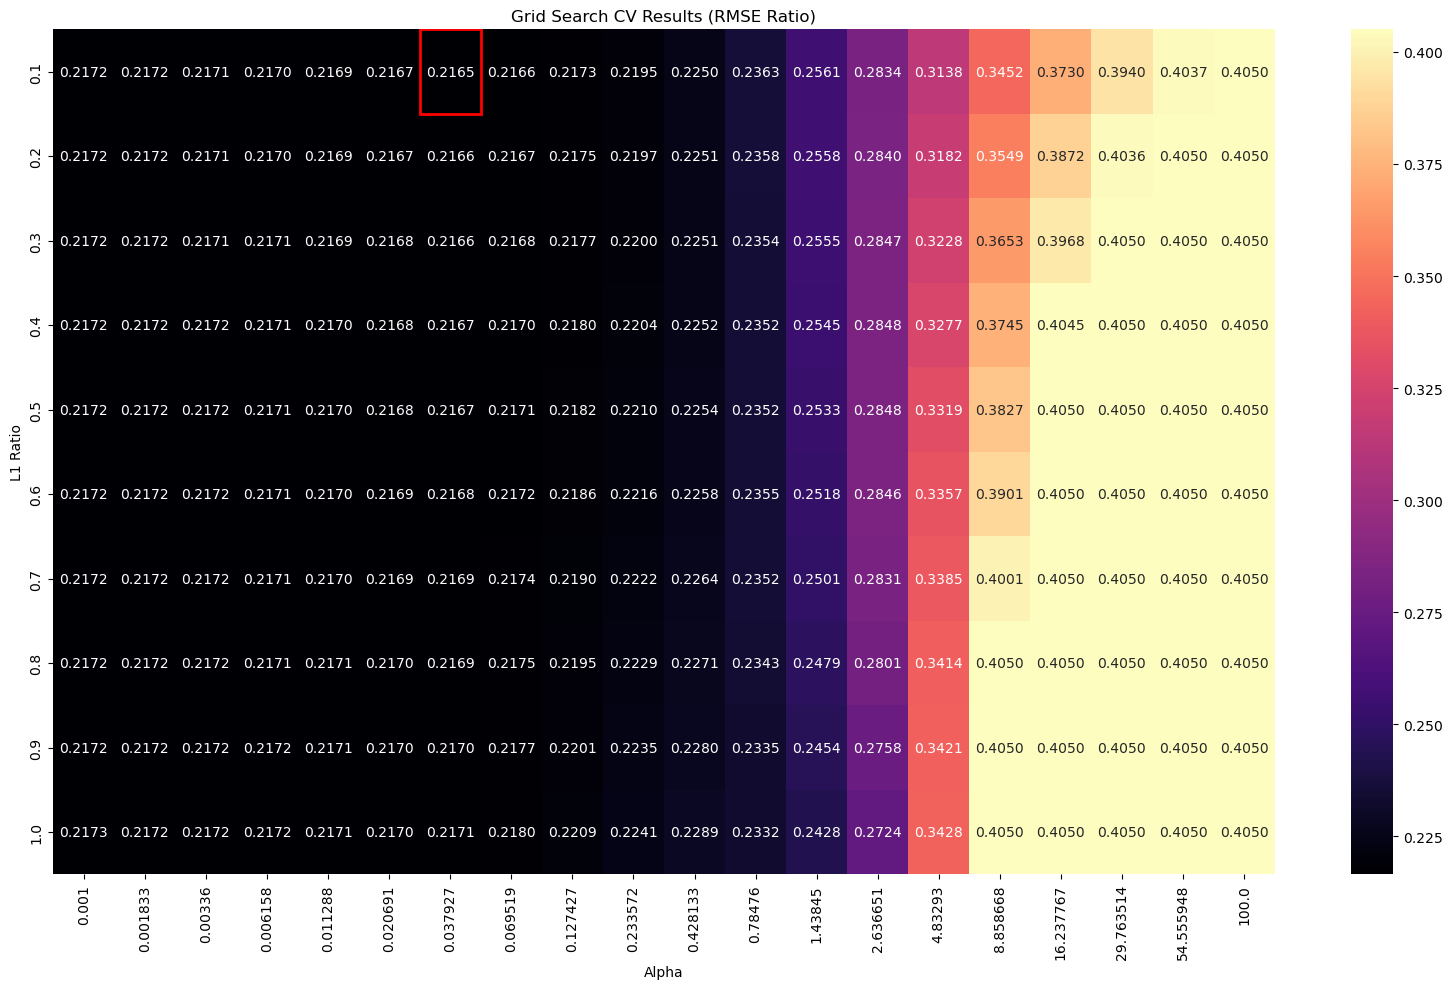

In [57]:
from matplotlib import patches

# DataFrame of results
results_custom = pd.DataFrame(grid_search_custom.cv_results_)

# Pivot and convert to positive values
heatmap_custom = results_custom.pivot_table(
    index='param_l1_ratio'
    , columns='param_alpha'
    , values='mean_test_score'
)

# Since RMSE and RMSE ratio scorers were negated (greater_is_better=False)
heatmap_custom = -1 * heatmap_custom

# Identify the location of the best score (lowest RMSE)
best_idx = np.unravel_index(
    np.argmin(heatmap_custom.values)  # Find the index of the min value
    , heatmap_custom.shape               # Shape of the heatmap for unraveling
)

# Plot
plt.figure(figsize=(16, 10))
ax = sns.heatmap(
    heatmap_custom
    , annot=True
    , fmt=".4f"
    , cmap="magma"
)

# Add a rectangle around the best score
highlight_rect = patches.Rectangle(
    (best_idx[1], best_idx[0])  # x, y (in heatmap coordinates)
    , 1, 1                        # width, height of the rectangle
    , fill=False                  # Don't fill the rectangle
    , edgecolor='red'             # Red border for the rectangle
    , linewidth=2                  # Thickness of the border
)
ax.add_patch(highlight_rect)

# Titles and labels
plt.title("Grid Search CV Results (RMSE Ratio)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()